In [1]:
%matplotlib inline

from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True

# CORRELATION FEATURES
num_features = 3

# NOTES
""

def numerical_labels(df):
    l = []
    for label in df.columns:
        if df[label].dtype in ["int32", "float32", "float64", "int64"]:
            l.append(label)
    return l

def square_root(series):
  return series.apply(lambda x:math.sqrt(x))

def log_normalize(series, base=10):
  return series.apply(lambda x:math.log(x, base))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

def preprocess_features(dataframe):
    """Prepares input features from California housing data set.

    Args:
    dataframe: A Pandas DataFrame expected to contain data
        from the California housing data set.
    Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    """
    labels = set(numerical_and_correlated)
    for l in dataframe.columns:
        if l.startswith("neigh_"):
            labels.add(l)
    clip_labels = []
    log_labels = []
    selected_features = dataframe[list(labels)]
    processed_features = selected_features.copy()
    for label in labels:
        processed_features[label].fillna(value=0, inplace=True)
    
    # Synth_185etic Feature
    processed_features['TotalSF'] = (
        dataframe['BsmtFinSF1'].fillna(0) +
        dataframe['BsmtFinSF2'].fillna(0) +
        dataframe['1stFlrSF'].fillna(0) +
        dataframe['2ndFlrSF'].fillna(0)
    )
    processed_features['Baths'] = (dataframe['FullBath'].fillna(0) + dataframe['HalfBath'].fillna(0))
    
    # Clip Outliers
    for label in clip_labels:
        s = processed_features[label]
        mx = s.mean() + 3 * s.std()
        processed_features[label] = clip(s, 0, mx)
        
    # Log Normalize
    for label in log_labels:
        if label in labels:
            s = processed_features[label]
            processed_features[label] = log_normalize(s)

    return processed_features

def preprocess_targets(dataframe):
    """Prepares target features (i.e., labels) from California housing data set.

    Args:
    dataframe: A Pandas DataFrame expected to contain data
        from the California housing data set.
    Returns:
    A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Scale the target to be logarithmic.
    # output_targets["SalePrice"] = np.log(dataframe["SalePrice"])
    output_targets["SalePrice"] = dataframe["SalePrice"] / 1000.0
    return output_targets

def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def train_regression_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    hidden_units=[],
    dnn=True):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  if dnn:
    my_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
    )
  else:
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer,
    )
    
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training {}model...".format("DNN " if dnn else "Linear "))
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return regressor

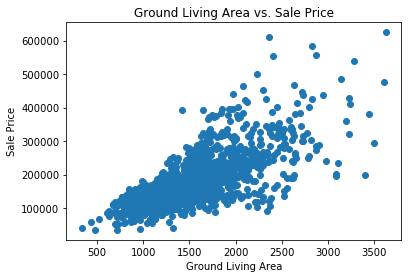

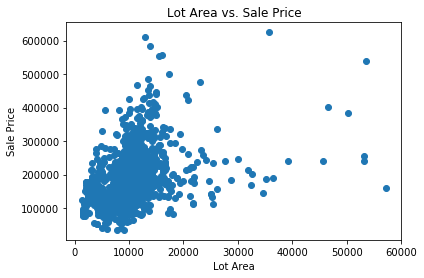

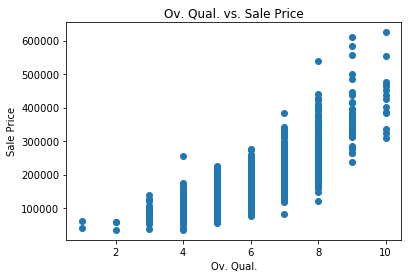

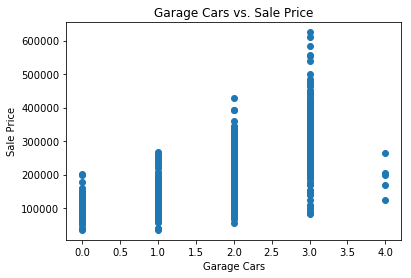

In [2]:
housing_dataframe = pd.read_csv("/home/wesleytocs/.kaggle/competitions/house-prices-advanced-regression-techniques/train.csv", sep=",")
housing_dataframe = housing_dataframe.reindex(
    np.random.permutation(housing_dataframe.index))
house_ids = housing_dataframe.pop('Id')
#housing_dataframe["OverallQual"] = log_normalize(housing_dataframe["OverallQual"])

# One Hot Encode Neighborhood
neighborhoods = housing_dataframe["Neighborhood"].unique()
mapping = dict()
for i in range(len(neighborhoods)):
    mapping["neigh_" + neighborhoods[i]] = i + 1
housing_dataframe["Neighborhood"] = pd.Series([mapping["neigh_" + x] for x in housing_dataframe["Neighborhood"]], dtype="int32")
for n in mapping.keys():
    housing_dataframe[n] = pd.Series([1 if x == mapping[n] else 0 for x in housing_dataframe["Neighborhood"]])
housing_dataframe.drop(["Neighborhood"], axis=1, inplace=True)

# Get Highly Correlated Numerical Features
correlated_labels = housing_dataframe.corr().sort_values("SalePrice", ascending=False)["SalePrice"].index[1:1 + num_features]
correlated_df_f = housing_dataframe[correlated_labels]
numerical_and_correlated = numerical_labels(correlated_df_f)
    
# DROP OUTLIERS
indices = housing_dataframe[(housing_dataframe['GrLivArea']>4000)].index
housing_dataframe.drop(indices, inplace=True)
indices = housing_dataframe[(housing_dataframe['LotArea']>60000)].index
housing_dataframe.drop(indices, inplace=True)

# Scale Large Numerical Values
housing_dataframe["YearBuilt"] = housing_dataframe["YearBuilt"] - 1872.0
housing_dataframe["YrSold"] = housing_dataframe["YrSold"] - 2006

if PLOT:
    plt.xlabel("Ground Living Area")
    plt.ylabel("Sale Price")
    plt.title("Ground Living Area vs. Sale Price")
    plt.scatter(housing_dataframe["GrLivArea"], housing_dataframe["SalePrice"])
    plt.show()
if PLOT:
    plt.xlabel("Lot Area")
    plt.ylabel("Sale Price")
    plt.title("Lot Area vs. Sale Price")
    plt.scatter(housing_dataframe["LotArea"], housing_dataframe["SalePrice"])
    plt.show()
if PLOT:
    plt.xlabel("Ov. Qual.")
    plt.ylabel("Sale Price")
    plt.title("Ov. Qual. vs. Sale Price")
    plt.scatter(housing_dataframe["OverallQual"], housing_dataframe["SalePrice"])
    plt.show()
if PLOT:
    plt.xlabel("Garage Cars")
    plt.ylabel("Sale Price")
    plt.title("Garage Cars vs. Sale Price")
    plt.scatter(housing_dataframe["GarageCars"], housing_dataframe["SalePrice"])
    plt.show()

# Split the dataset 80/20 for training and validation, respectively
df_size = housing_dataframe.shape[0]
t_size = int(0.8 * df_size)
v_size = df_size - t_size

training_examples = preprocess_features(housing_dataframe.head(t_size))
training_targets = preprocess_targets(housing_dataframe.head(t_size))

validation_examples = preprocess_features(housing_dataframe.tail(v_size))
validation_targets = preprocess_targets(housing_dataframe.tail(v_size))

In [3]:
# Double-check that we've done the right thing.
if SUMMARIZE:
    print("Input summary:")
    display.display(housing_dataframe.describe())
    print("Training examples summary:")
    display.display(training_examples.describe())
    print("Validation examples summary:")
    display.display(validation_examples.describe())
    print("Training targets summary:")
    display.display(training_targets.describe())
    print("Validation targets summary:")
    display.display(validation_targets.describe())

Input summary:


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,neigh_CollgCr,neigh_MeadowV,neigh_Timber,neigh_NPkVill,neigh_BrDale,neigh_Sawyer,neigh_Crawfor,neigh_StoneBr,neigh_ClearCr,neigh_NoRidge
count,1451.0,1195.0,1451.0,1451.0,1451.0,1451.0,1451.0,1443.0,1451.0,1451.0,...,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0,1451.0
mean,56.9,69.6,9985.3,6.1,5.6,99.2,1984.8,101.9,435.0,46.2,...,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0
std,42.3,23.0,5171.2,1.4,1.1,30.3,20.7,177.2,429.4,160.5,...,0.3,0.1,0.2,0.1,0.1,0.2,0.2,0.1,0.1,0.2
min,20.0,21.0,1300.0,1.0,1.0,0.0,1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,20.0,59.0,7517.5,5.0,5.0,82.0,1967.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,50.0,69.0,9452.0,6.0,5.0,101.0,1994.0,0.0,379.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,70.0,80.0,11506.0,7.0,6.0,128.0,2004.0,164.0,705.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,190.0,313.0,57200.0,10.0,9.0,138.0,2010.0,1600.0,2188.0,1474.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Training examples summary:


,neigh_Blmngtn,neigh_NAmes,neigh_Blueste,neigh_Somerst,neigh_NridgHt,GrLivArea,neigh_StoneBr,neigh_Mitchel,OverallQual,neigh_Gilbert,...,neigh_Timber,neigh_NPkVill,neigh_BrDale,neigh_Sawyer,neigh_Crawfor,neigh_ClearCr,GarageCars,neigh_NoRidge,TotalSF,Baths
count,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,...,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0,1160.0
mean,0.0,0.2,0.0,0.1,0.1,1500.6,0.0,0.0,6.1,0.1,...,0.0,0.0,0.0,0.1,0.0,0.0,1.8,0.0,1972.7,1.9
std,0.1,0.4,0.0,0.2,0.2,488.5,0.1,0.2,1.4,0.2,...,0.2,0.1,0.1,0.2,0.2,0.1,0.7,0.2,685.9,0.8
min,0.0,0.0,0.0,0.0,0.0,334.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,1128.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1499.8,1.0
50%,0.0,0.0,0.0,0.0,0.0,1456.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1871.0,2.0
75%,0.0,0.0,0.0,0.0,0.0,1768.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2349.8,3.0
max,1.0,1.0,1.0,1.0,1.0,3627.0,1.0,1.0,10.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,5014.0,4.0


Validation examples summary:


,neigh_Blmngtn,neigh_NAmes,neigh_Blueste,neigh_Somerst,neigh_NridgHt,GrLivArea,neigh_StoneBr,neigh_Mitchel,OverallQual,neigh_Gilbert,...,neigh_Timber,neigh_NPkVill,neigh_BrDale,neigh_Sawyer,neigh_Crawfor,neigh_ClearCr,GarageCars,neigh_NoRidge,TotalSF,Baths
count,291.0,291.0,291.0,291.0,291.0,291.0,291.0,291.0,291.0,291.0,...,291.0,291.0,291.0,291.0,291.0,291.0,291.0,291.0,291.0,291.0
mean,0.0,0.2,0.0,0.1,0.1,1523.9,0.0,0.0,6.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.8,0.0,2011.8,2.0
std,0.1,0.4,0.1,0.3,0.2,530.4,0.1,0.1,1.4,0.2,...,0.2,0.1,0.1,0.2,0.2,0.1,0.8,0.2,775.7,0.8
min,0.0,0.0,0.0,0.0,0.0,438.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,520.0,1.0
25%,0.0,0.0,0.0,0.0,0.0,1118.5,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1457.0,1.0
50%,0.0,0.0,0.0,0.0,0.0,1459.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1832.0,2.0
75%,0.0,0.0,0.0,0.0,0.0,1794.5,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2494.0,3.0
max,1.0,1.0,1.0,1.0,1.0,3395.0,1.0,1.0,10.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,4695.0,4.0


Training targets summary:


,SalePrice
count,1160.0
mean,177.7
std,74.6
min,34.9
25%,129.9
50%,160.1
75%,207.1
max,625.0


Validation targets summary:


,SalePrice
count,291.0
mean,188.1
std,83.3
min,37.9
25%,129.5
50%,170.0
75%,228.5
max,538.0


Training DNN model...
RMSE (on training data):
  period 00 : 42.09
  period 01 : 37.32
  period 02 : 34.73
  period 03 : 33.40
  period 04 : 45.01
  period 05 : 33.92
  period 06 : 35.56
  period 07 : 38.56
  period 08 : 32.15
  period 09 : 32.41
Model training finished.
Final RMSE (on training data):   32.41
Final RMSE (on validation data): 34.97


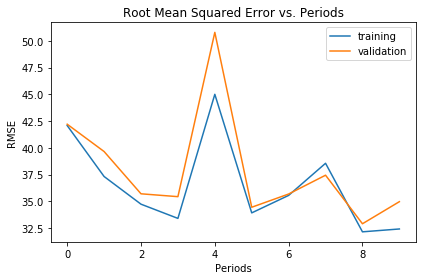

In [4]:
regressor = train_regression_model(
    learning_rate=0.001,
    steps=50000,
    batch_size=25,
    hidden_units=[10, 10, 7],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    dnn=True)

Test Data summary:


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,neigh_SWISU,neigh_Edwards,neigh_CollgCr,neigh_Crawfor,neigh_Blueste,neigh_IDOTRR,neigh_Mitchel,neigh_Timber,neigh_MeadowV,neigh_Veenker
count,1459.0,1232.0,1459.0,1459.0,1459.0,1459.0,1459.0,1444.0,1458.0,1458.0,...,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0,1459.0
mean,57.4,68.6,9819.2,6.1,5.6,99.4,1983.7,100.7,439.2,52.6,...,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,42.7,22.4,4955.5,1.4,1.1,30.4,21.1,177.6,455.3,176.8,...,0.1,0.2,0.3,0.2,0.1,0.2,0.2,0.2,0.1,0.1
min,20.0,21.0,1470.0,1.0,1.0,7.0,1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,20.0,58.0,7391.0,5.0,5.0,81.0,1963.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,50.0,67.0,9399.0,6.0,5.0,101.0,1992.0,0.0,350.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,70.0,80.0,11517.5,7.0,6.0,129.0,2004.0,164.0,753.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,190.0,200.0,56600.0,10.0,9.0,138.0,2010.0,1290.0,4010.0,1526.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Test Output summary:


,Id,SalePrice
count,1459.0,1459.0
mean,2190.0,179.2
std,421.3,16.5
min,1461.0,135.8
25%,1825.5,168.7
50%,2190.0,179.2
75%,2554.5,186.8
max,2919.0,281.6


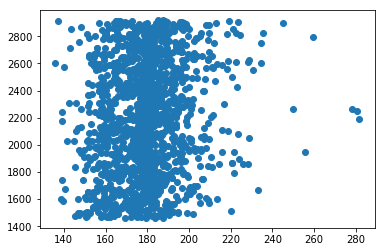

In [5]:
test_data = pd.read_csv("/home/wesleytocs/.kaggle/competitions/house-prices-advanced-regression-techniques/test.csv", sep=",")
ids = test_data.pop('Id')
test_data["YearBuilt"] = test_data["YearBuilt"] - 1872
test_data["YrSold"] = test_data["YrSold"] - 2006
#test_data["OverallQual"] = log_normalize(test_data["OverallQual"])


test_neighborhoods = test_data["Neighborhood"].unique()
for n in test_neighborhoods:
    if n in neighborhoods:
        test_data["neigh_" + n] = pd.Series([1 if x == n else 0 for x in test_data["Neighborhood"]])
test_data.drop(["Neighborhood"], axis=1, inplace=True)

if SUMMARIZE:
    print("Test Data summary:")
    display.display(test_data.describe())  

test_output = pd.read_csv("/home/wesleytocs/.kaggle/competitions/house-prices-advanced-regression-techniques/sample_submission.csv", sep=",")
#test_output["SalePrice"] = np.log(test_output["SalePrice"])
test_output["SalePrice"] = test_output["SalePrice"] / 1000.0

if SUMMARIZE:
    print("Test Output summary:")
    display.display(test_output.describe())
if PLOT:
    plt.scatter(test_output["SalePrice"], test_output["Id"])
    plt.show()

Test Predictions summary:


,SalePrice
count,1459.0
mean,172.3
std,69.9
min,6.7
25%,123.3
50%,161.4
75%,210.0
max,630.5


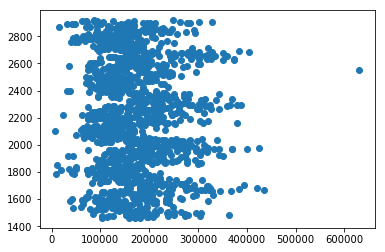

RMSE: 185.81


In [6]:
test_examples = preprocess_features(test_data)
test_targets = preprocess_targets(test_output)

fn = lambda: my_input_fn(test_examples, test_targets["SalePrice"], num_epochs=1, shuffle=False)
test_predictions = pd.DataFrame()
test_predictions["SalePrice"] = pd.Series([item['predictions'][0] for item in regressor.predict(input_fn=fn)])

if SUMMARIZE:
    print("Test Predictions summary:")
    display.display(test_predictions.describe())
    
rmse = math.sqrt(metrics.mean_squared_error(test_predictions["SalePrice"], test_targets["SalePrice"]))

final = pd.DataFrame({'Id': ids, 'SalePrice': test_predictions["SalePrice"] * 1000.0})
final.to_csv('output_RMSE{:.2f}_{}corr.csv'.format(rmse, num_features), index=False)
if PLOT:
    plt.scatter(final["SalePrice"], final["Id"])
    plt.show()

print("RMSE: {:.2f}".format(rmse))